In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from Common import NeuralNet, MultiVariatePoly
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)
# torch.manual_seed
import pandas as pd

import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam

### FNO

The Temperature evolution of the solid and fluid phases $T_S$a nd $T_f$ is described by a sdystem of two linear reaction-convection diffusion equation $$\begin{aligned} \varepsilon \rho_{f} C_{f} \frac{\partial T_{f}}{\partial t}+\varepsilon \rho_{f} C_{f} u_{f}(t) \frac{\partial T_{f}}{\partial x}=\lambda_{f} \frac{\partial^{2} T_{f}}{\partial x^{2}}-h_{v}\left(T_{f}-T_{s}\right) & x \in[0, L], t \in[0, T] \\ (1-\varepsilon) \rho_{s} C_{s} \frac{\partial T_{s}}{\partial t}=\lambda_{s} \frac{\partial^{2} T_{s}}{\partial x^{2}}+h_{v}\left(T_{f}-T_{s}\right) & x \in[0, L], t \in[0, T]\end{aligned}$$


### Learning Operators

Mapping between two infinite dimensional spaces from a finite collection of observed input-output pairs (i.e $(t, T_s)$ and $(t, T_f)$)

We want to find a solution operator (map) $G^\dagger$ of the parametric PDE above by constructing a parametric map $$ G_\theta: \mathcal{A} \rightarrow \mathcal{U}$$ for some parameter $\theta^\dagger \in \Theta$ (where $\Theta$ is some finite dimensional parameter space), such that this approximation map $$G(\cdot, \theta^\dagger) = G_{\theta^\dagger} \simeq G^\dagger$$

Approximating this solution operator $G^\dagger$ is different than finding the solution $u \in \mathcal{U}$ of a PDE for a single instance of the parameter $a \in \mathcal{A}$

## Operator Learning

- The spatial domain for the PDE $D \subset \mathbb{R}^d$ (in our case simply $t \in \mathbb{R}$, where $t$ correspond to the points in the spatial domain)
- $a \in \mathcal{A} = (D; \mathbb{R}^{d_a})$ are the **input coefficient functions**
- $u \in \mathcal{U} = (D; \mathbb{R}^{d_u})$ are the **target solution functions**

Given a set of observations s $\{a_j, u_j\}_{j =1}^N$, the function $D_j$ describes the discretization of $(a_j, u_j)$

,t,tf0,ts0
0,0.00,873.000000,293.000000
1,2478.06,873.000000,655.920736
2,4956.12,873.000000,792.106226
3,7434.18,873.000000,842.176577
4,9912.24,873.000000,861.040655
...,...,...,...
205,508002.30,730.794575,730.514961
206,510480.36,730.053663,729.797475
207,512958.42,729.371039,729.133162
208,515436.48,728.734400,728.511278


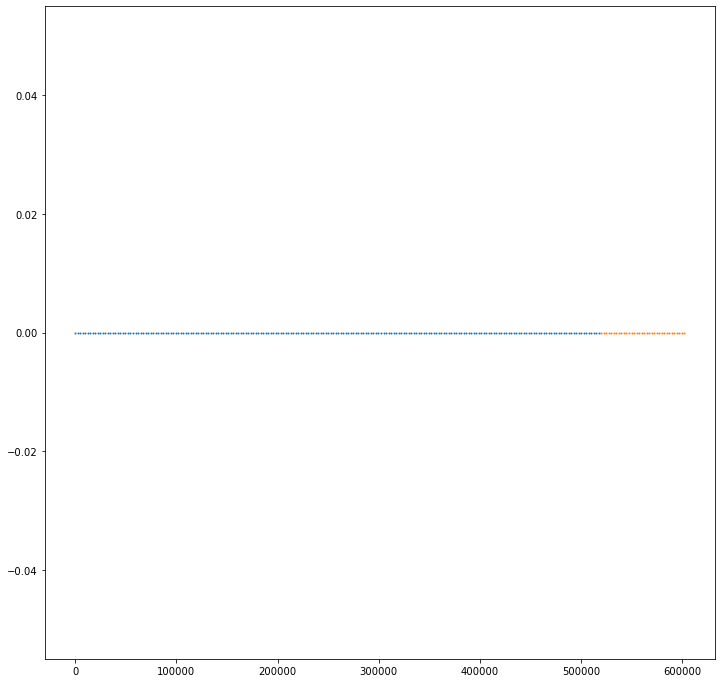

In [190]:
train_data = pd.read_csv("Task3/TrainingData.txt")
test_data = pd.read_csv("Task3/TestingData.txt")
display(train_data)
# display(test_data)

fig, ax = plt.subplots(1,1, figsize = (12, 12))


plt.scatter(train_data['t'],[0 for x in train_data['t']], s = 1)
plt.scatter(test_data['t'], [0 for x in test_data['t']], s = 1)

t_train_import = torch.from_numpy(train_data['t'].to_numpy()).type(torch.float32)
t_pred = torch.from_numpy(test_data['t'].to_numpy()).type(torch.float32)

Tf0 = torch.from_numpy(train_data['tf0'].to_numpy()).type(torch.float32)
Ts0 = torch.from_numpy(train_data['ts0'].to_numpy()).type(torch.float32)

### Normalize Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# load data
# create scaler
scaler_t = MinMaxScaler()
scaler_Tf = MinMaxScaler()
scaler_Ts = MinMaxScaler()
# # inverse transform
# inverse = scaler.inverse_transform(normalized)

t_train_norm = scaler_t.fit_transform(train_data['t'].to_numpy().reshape(-1, 1))
t_test_norm = scaler_t.fit_transform(test_data['t'].to_numpy().reshape(-1, 1))
Tf0_norm = scaler_Tf.fit_transform(train_data['tf0'].to_numpy().reshape(-1, 1))
Ts0_norm = scaler_Ts.fit_transform(train_data['ts0'].to_numpy().reshape(-1, 1))

#### Plot Unnormalized and Normalized Data

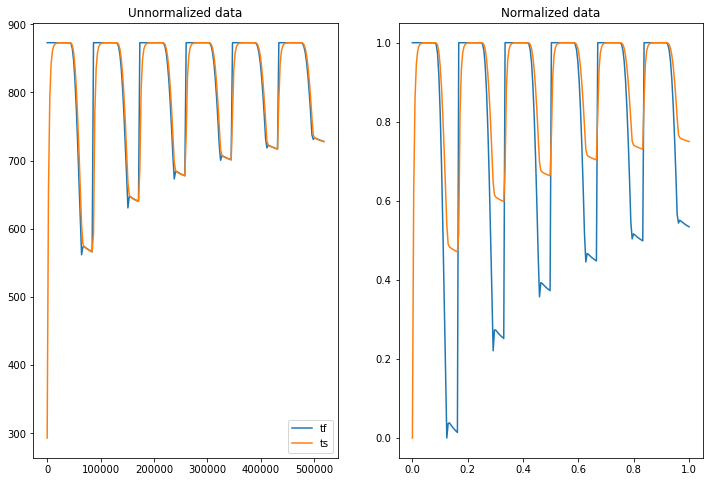

In [155]:
fig, ax = plt.subplots(1,2, figsize = (12, 8))

ax[0].plot(t_train_import, Tf0, label = "tf")
ax[0].plot(t_train_import, Ts0, label = 'ts')
ax[0].legend()
ax[0].set_title("Unnormalized data")

ax[1].plot(t_train_norm, Tf0_norm, label = 'tf_norm')
ax[1].plot(t_train_norm, Ts0_norm, label = 'ts_norm')
ax[1].set_title("Normalized data")

plt.show()

Split the training and testing set into 6 subsets of 35 points where the last one is used as testing set

In [176]:
n_train = 175
batch_dim = 35
batch_size = 2


t_train = torch.tensor(t_train_norm[:n_train].reshape(-1), dtype=torch.float32)
Tf_train = torch.tensor(Tf0_norm[:n_train].reshape(-1),  dtype=torch.float32)
Ts_train = torch.tensor(Ts0_norm[:n_train].reshape(-1),  dtype=torch.float32)

t_test = torch.tensor(t_train_norm[n_train:].reshape(-1), dtype=torch.float32)
Tf_test = torch.tensor(Tf0_norm[n_train:].reshape(-1), dtype = torch.float32)
Ts_test = torch.tensor(Ts0_norm[n_train:].reshape(-1), dtype = torch.float32)

print("Training size: {}".format(len(t_train)))
print("Testing size: {}".format(len(t_test)))

input_Tf_train = torch.stack([Tf_train, t_train], dim = 1).reshape(-1, batch_dim, 2)
print(input_Tf_train.shape)
input_Tf_test = torch.stack([Tf_test, t_test], dim = 1).reshape(-1, batch_dim, 2) 
print(input_Tf_test.shape)

output_Tf_train = Tf_train.reshape(-1, batch_dim)
output_Tf_test = Tf_test.reshape(-1, batch_dim)
print(output_Tf_train.shape)
print(output_Tf_test.shape)

input_Ts_train = torch.stack([Ts_train, t_train], dim = 1).reshape(-1, batch_dim, 2)
input_Ts_test = torch.stack([Ts_test, t_test], dim = 1).reshape(-1, batch_dim, 2)

output_Ts_train = Ts_train.reshape(-1, batch_dim)
output_Ts_test = Ts_test.reshape(-1, batch_dim)

Training size: 175
Testing size: 35
torch.Size([5, 35, 2])
torch.Size([1, 35, 2])
torch.Size([5, 35])
torch.Size([1, 35])


In [177]:
training_set_Tf = DataLoader(TensorDataset(input_Tf_train, output_Tf_train), batch_size=batch_size, shuffle=True)
testing_set_Tf = DataLoader(TensorDataset(input_Tf_test, output_Tf_test), batch_size=batch_size, shuffle=True)

training_set_Ts = DataLoader(TensorDataset(input_Ts_train, output_Ts_train), batch_size=batch_size, shuffle=True)
testing_set_Ts = DataLoader(TensorDataset(input_Ts_test, output_Ts_test), batch_size=batch_size, shuffle=True)

### FNO1D Implementation

In [178]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')


################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)


    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform
        
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


####################################################################


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x)

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        # grid = self.get_grid(x.shape, x.device)
        # x = torch.cat((x, grid), dim=-1)
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

        # x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x

In [146]:
learning_rate = 0.001

# epochs = 250
epochs = 1000
step_size = 50
gamma = 0.5

modes = 16
width = 64

# model

fno_Tf = FNO1d(modes, width)
fno_Ts = FNO1d(modes, width) 

#### Optimizer for $T_f$

In [147]:
optimizer = Adam(fno_Tf.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 10
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_Tf):
        # print(input_batch.shape)
        # print(output_batch.shape)
        optimizer.zero_grad()
        # print(input_batch.shape)
        # print(fno(input_batch).shape)
        output_pred_batch = fno_Tf(input_batch).squeeze(2) # gives you the prediction of T_s or T_f
        # print(output_pred_batch)
        # print(output_batch)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_Tf)
    # print(train_mse)

    scheduler.step()

    with torch.no_grad():
        # print("=========")
        # print("Testing Set")
        fno_Tf.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set_Tf):
            output_pred_batch = fno_Tf(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set_Tf)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)


######### Epoch: 0  ######### Train Loss: 0.31943681339422864  ######### Relative L2 Test Norm: 31.655874252319336
######### Epoch: 10  ######### Train Loss: 0.0057707857340574265  ######### Relative L2 Test Norm: 3.4263718128204346
######### Epoch: 20  ######### Train Loss: 0.00047638096536199254  ######### Relative L2 Test Norm: 3.270528554916382
######### Epoch: 30  ######### Train Loss: 0.00032658519436760497  ######### Relative L2 Test Norm: 2.12505841255188
######### Epoch: 40  ######### Train Loss: 0.00028284289995402406  ######### Relative L2 Test Norm: 1.675201416015625
######### Epoch: 50  ######### Train Loss: 0.00012418929812459586  ######### Relative L2 Test Norm: 1.209648847579956
######### Epoch: 60  ######### Train Loss: 0.00014061470938031562  ######### Relative L2 Test Norm: 1.486842393875122
######### Epoch: 70  ######### Train Loss: 0.0001365590518010625  ######### Relative L2 Test Norm: 1.3265180587768555
######### Epoch: 80  ######### Train Loss: 8.113033982226625

### Result of Testing Prediction

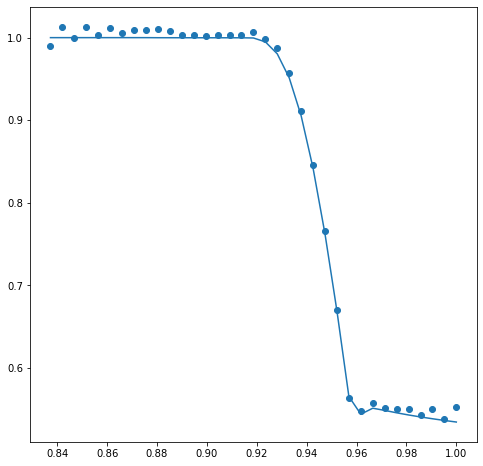

In [163]:
for step, (input_batch, output_batch) in enumerate(testing_set_Tf):
        output_pred_batch = fno_Tf(input_batch).squeeze(2)
        fig, ax =  plt.subplots(1,1, figsize = (8, 8))
        plt.scatter(input_batch[0, :,1].detach(), output_pred_batch[0,:].detach())
        plt.plot(input_batch[0,:, 1],output_batch[0,:] )

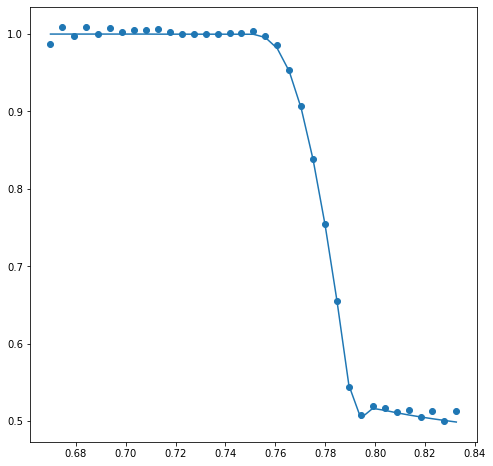

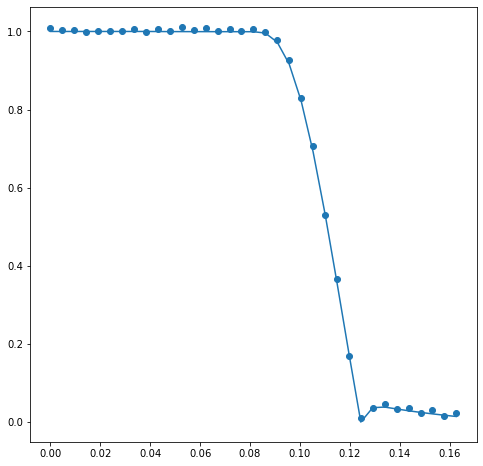

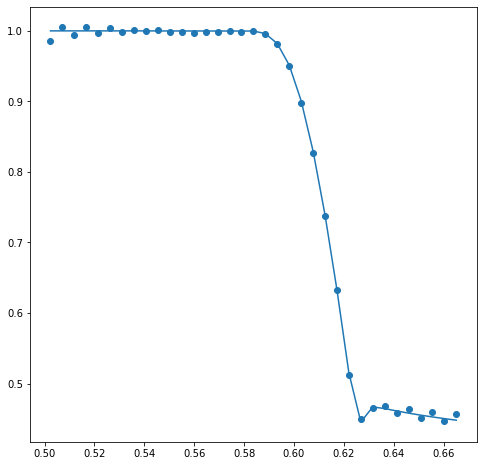

In [166]:
for step, (input_batch, output_batch) in enumerate(training_set_Tf):
    output_pred_batch = fno_Tf(input_batch).squeeze(2)
    fig, ax = plt.subplots(1,1, figsize = (8,8))
    plt.scatter(input_batch[0, :,1].detach(), output_pred_batch[0,:].detach())
    plt.plot(input_batch[0,:, 1],output_batch[0,:] )

torch.Size([35])
torch.Size([35])
torch.Size([35])
torch.Size([35])
torch.Size([35])


ValueError: x and y must have same first dimension, but have shapes torch.Size([0]) and torch.Size([35])

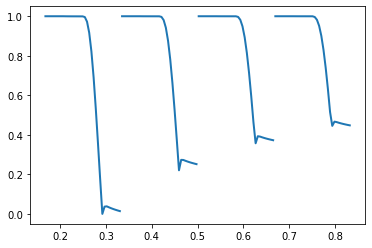

In [175]:
for idx, t in enumerate(input_Tf_train):
    input_function_test_n = input_Tf_train[idx, :].unsqueeze(0)
    output_function_test_n = output_Tf_train[idx, :].unsqueeze(0)

    output_function_test_pred_n = fno_Tf(input_function_test_n)

    print(output_function_test_n[0].shape)

    plt.plot(input_Tf_train.reshape(-1,2)[(idx+1)*batch_dim:(idx+1)*batch_dim+batch_dim, 1].detach(), output_function_test_n[0].detach(), label="True Solution", c="C0", lw=2)
    # plt.scatter(input_Tf_train.reshape(-1,2)[(idx+1)*batch_dim:(idx+1)*batch_dim+batch_dim, 1].detach(), output_function_test_pred_n[0].detach(), label="Approximate Solution", s=8, c="C0")

#### Get Prediction for test_set

### Optimizer $T_S$

In [179]:
optimizer = Adam(fno_Ts.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 4
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_Ts):
        # print(input_batch.shape)
        # print(output_batch.shape)
        optimizer.zero_grad()
        # print(input_batch.shape)
        # print(fno(input_batch).shape)
        output_pred_batch = fno_Ts(input_batch).squeeze(2) # gives you the prediction of T_s or T_f
        # print(output_pred_batch)
        # print(output_batch)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_Ts)
    # print(train_mse)

    scheduler.step()

    with torch.no_grad():
        # print("=========")
        # print("Testing Set")
        fno_Ts.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set_Ts):
            output_pred_batch = fno_Ts(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set_Ts)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)


######### Epoch: 0  ######### Train Loss: 0.012547182074437538  ######### Relative L2 Test Norm: 3.647730588912964
######### Epoch: 4  ######### Train Loss: 0.0023204560857266188  ######### Relative L2 Test Norm: 2.3475093841552734
######### Epoch: 8  ######### Train Loss: 0.0010738213507769008  ######### Relative L2 Test Norm: 2.8249447345733643
######### Epoch: 12  ######### Train Loss: 0.0003788095636991784  ######### Relative L2 Test Norm: 1.158982753753662
######### Epoch: 16  ######### Train Loss: 0.00011641287225453804  ######### Relative L2 Test Norm: 0.6941078901290894
######### Epoch: 20  ######### Train Loss: 9.973172564059496e-05  ######### Relative L2 Test Norm: 0.8530887961387634
######### Epoch: 24  ######### Train Loss: 0.00010839125146352065  ######### Relative L2 Test Norm: 0.6978062391281128
######### Epoch: 28  ######### Train Loss: 5.771661259738418e-05  ######### Relative L2 Test Norm: 0.8706308007240295
######### Epoch: 32  ######### Train Loss: 4.311098139927102

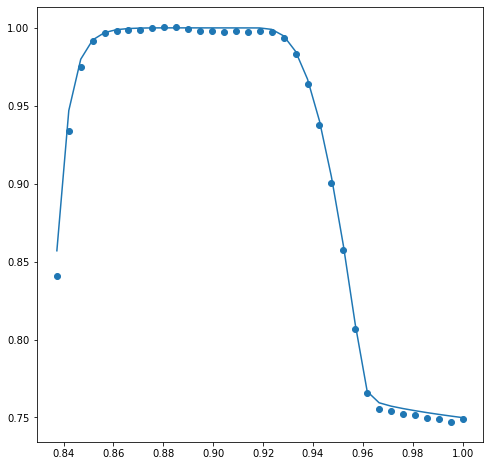

In [180]:
for step, (input_batch, output_batch) in enumerate(testing_set_Ts):
        output_pred_batch = fno_Ts(input_batch).squeeze(2)
        fig, ax =  plt.subplots(1,1, figsize = (8, 8))
        plt.scatter(input_batch[0, :,1].detach(), output_pred_batch[0,:].detach())
        plt.plot(input_batch[0,:, 1],output_batch[0,:])

# Archive

#### Get prediction with 2D Data

In [ ]:
# idx_data = 4
input_function_train_n = input_train
output_function_train_tf = Tf0_train


output_function_train_pred_n = fno(input_function_train_n)
# print(output_function_test_pred_n.shape)
output_function_train_pred_n = output_function_train_pred_n.detach()[0,:,0]
print(output_function_train_pred_n.shape)
print(input_function_train_n[:,0].shape)
# print(input_function_test_n[0,:,1])
plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")
plt.scatter(input_function_train_n[:,0], output_function_train_pred_n, label="Approximate Solution", s=2, c="red")
plt.plot(input_function_train_n, output_function_train_tf, label="True Solution", c="C0", lw=2)
p = 2
err = (torch.mean(abs(output_function_train_tf.detach().reshape(-1, ) - output_function_train_pred_n.detach().reshape(-1, )) ** p) / torch.mean(abs(output_function_train_tf.detach()) ** p)) ** (1 / p) * 100
print("Relative L2 error: ", err.item())
plt.legend()


In [ ]:
input_function_test_n = input_test
# print(len(input_function_test_n))
output_function_test_tf = Tf0_test


output_function_test_pred_n = fno(input_function_test_n)
# print(output_function_test_pred_n.shape)
output_function_test_pred_n = output_function_test_pred_n.detach()[0,:,0]
print(output_function_test_pred_n.shape)
print(input_function_test_n[:,0].shape)
# print(input_function_test_n[0,:,1])
plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")
plt.scatter(input_function_test_n[:,0], output_function_test_pred_n, label="Approximate Solution", s=8, c="C0")
plt.plot(input_function_test_n, output_function_test_tf, label="True Solution", c="C0", lw=2)


#### Optimizer with (t, T_f)


In [ ]:
n_train = 178 # 85 percent
# Input set
t_train = t_train_norm[:n_train].reshape(-1,1)
t_test =  t_train_norm[n_train:].reshape(-1,1)

t_train = torch.from_numpy(t_train).type(torch.float32)
t_test = torch.from_numpy(t_test).type(torch.float32)


Tf0_norm_torch = torch.from_numpy(Tf0_norm).type(torch.float32)
Ts0_norm_torch = torch.from_numpy(Ts0_norm).type(torch.float32)

# Output Set
Tf0_train = Tf0_norm_torch[:n_train]
Ts0_train = Ts0_norm_torch[:n_train]

Tf0_test = Tf0_norm_torch[n_train:]
Ts0_test = Ts0_norm_torch[n_train:]


input_train_tf0 = torch.cat((t_train, Tf0_train), 1)
input_test_tf0 = torch.cat((t_test, Tf0_test), 1)


print(input_train_tf0.shape)

training_set_tf0 = DataLoader(TensorDataset(input_train_tf0, Tf0_train), batch_size=batch_size, shuffle=True)
testing_set_tf0 =  DataLoader(TensorDataset(input_test_tf0, Ts0_test), batch_size=batch_size, shuffle=True)

batch_size = 178

# training_set_tf0 = DataLoader(TensorDataset(t_train, Tf0_train), batch_size=batch_size, shuffle=True)
# training_set_ts0 = DataLoader(TensorDataset(t_train, Ts0_train), batch_size=batch_size, shuffle=True)

# testing_set_tf0 = DataLoader(TensorDataset(t_test, Tf0_test), batch_size=batch_size, shuffle=True)
# testing_set_ts0 = DataLoader(TensorDataset(t_test, Ts0_test), batch_size=batch_size, shuffle=True)
# batch_size = 178

# training_set_tf0_2d = DataLoader(TensorDataset(input_train, Tf0_train), batch_size=batch_size, shuffle=True)
# training_set_ts0_2d = DataLoader(TensorDataset(input_train, Ts0_train), batch_size=batch_size, shuffle=True)

# testing_set_tf0_2d = DataLoader(TensorDataset(input_test, Tf0_test), batch_size=batch_size, shuffle=True)
# testing_set_ts0_2d = DataLoader(TensorDataset(input_test, Ts0_test), batch_size=batch_size, shuffle=True)

In [ ]:
epochs = 100
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_tf0):
        optimizer.zero_grad()
        # print(input_batch.shape)
        # print(fno(input_batch).shape)
        output_pred_batch = fno(input_batch)
        print("Output batch pred: {}".format(output_pred_batch))
        print("Output batch: {}".format(output_batch))
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_tf0)
    # print(train_mse)

    scheduler.step()

    with torch.no_grad():
        # print("=========")
        # print("Testing Set")
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set_tf0):
            output_pred_batch = fno(input_batch)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set_tf0)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)


In [ ]:
# idx_data = 4
input_function_train_n = input_train
output_function_train_tf = Tf0_train


output_function_train_pred_n = fno(input_function_train_n)
# print(output_function_test_pred_n.shape)
output_function_train_pred_n = output_function_train_pred_n.detach()[0,:,0]
print(output_function_train_pred_n.shape)
print(input_function_train_n[:,0].shape)
# print(input_function_test_n[0,:,1])
plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")
plt.scatter(input_function_train_n[:,0], output_function_train_pred_n, label="Approximate Solution", s=2, c="red")
plt.plot(input_function_train_n, output_function_train_tf, label="True Solution", c="C0", lw=2)
p = 2
err = (torch.mean(abs(output_function_train_tf.detach().reshape(-1, ) - output_function_train_pred_n.detach().reshape(-1, )) ** p) / torch.mean(abs(output_function_train_tf.detach()) ** p)) ** (1 / p) * 100
print("Relative L2 error: ", err.item())
plt.legend()


##### Optimizer with 1D Data

In [ ]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_tf0):
        optimizer.zero_grad()
        # print(input_batch.shape)
        # print(fno(input_batch).shape)
        output_pred_batch = fno(input_batch).squeeze(2) # gives you the prediction of T_s or T_f
        print(output_pred_batch)
        print(output_batch)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_tf0)
    # print(train_mse)

    scheduler.step()

    with torch.no_grad():
        # print("=========")
        # print("Testing Set")
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(testing_set_tf0):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set_tf0)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)


In [ ]:
# idx_data = 4
input_function_train_n = input_data_train
output_function_train_tf = Tf0_train

plt.plot(input_function_train_n, output_function_train_tf, label="True Solution", c="C0", lw=2)
output_function_train_pred_n = fno(input_function_train_n)
# print(output_function_test_pred_n.shape)
output_function_train_pred_n = output_function_train_pred_n.detach()[0,:,0]
print(output_function_train_pred_n.shape)
print(input_function_train_n[:,0].shape)
# print(input_function_test_n[0,:,1])
plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")
plt.scatter(input_function_train_n[:,0], output_function_train_pred_n, label="Approximate Solution", s=8, c="C0")


In [ ]:
input_function_test_n = input_data_test
output_function_test_tf = Tf0_test

plt.plot(input_function_test_n, output_function_test_tf, label="True Solution", c="C0", lw=2)
output_function_test_pred_n = fno(input_function_test_n)
# print(output_function_test_pred_n.shape)
output_function_test_pred_n = output_function_test_pred_n.detach()[0,:,0]
print(output_function_test_pred_n.shape)
print(input_function_test_n[:,0].shape)
# print(input_function_test_n[0,:,1])
plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")
plt.scatter(input_function_test_n[:,0], output_function_test_pred_n, label="Approximate Solution", s=8, c="C0")


### FNO 2D Implementation

In [ ]:
################################################################
#  2d fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class FNO2d(nn.Module):
    def __init__(self, fno_architecture, device=None, padding_frac=1 / 4):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """
        self.modes1 = fno_architecture["modes"]
        self.modes2 = fno_architecture["modes"]
        self.width = fno_architecture["width"]
        self.n_layers = fno_architecture["n_layers"]
        self.retrain_fno = fno_architecture["retrain_fno"]

        torch.manual_seed(self.retrain_fno)
        # self.padding = 9 # pad the domain if input is non-periodic
        self.padding_frac = padding_frac
        self.fc0 = nn.Linear(3, self.width)  # input channel is 3: (a(x, y), x, y)
        
        self.conv_list = nn.ModuleList(
            [nn.Conv2d(self.width, self.width, 1) for _ in range(self.n_layers)])
        self.spectral_list = nn.ModuleList(
            [SpectralConv2d(self.width, self.width, self.modes1, self.modes2) for _ in range(self.n_layers)])

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

        self.to(device)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1_padding = int(round(x.shape[-1] * self.padding_frac))
        x2_padding = int(round(x.shape[-2] * self.padding_frac))
        x = F.pad(x, [0, x1_padding, 0, x2_padding])

        for k, (s, c) in enumerate(zip(self.spectral_list, self.conv_list)):

            x1 = s(x)
            x2 = c(x)
            x = x1 + x2
            if k != self.n_layers - 1:
                x = F.gelu(x)
        x = x[..., :-x1_padding, :-x2_padding]

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x